# Сегментация изображений

Сегментация изображения — задача поиска групп пикселей, каждая из которых
характеризует один смысловой объект. В статистике эта проблема известна как
кластерный анализ и является широко изученной областью с сотнями различных 
алгоритмов. В компьютерном зрении сегментация изображения является одной из 
старейших и широко изучаемых проблем.


**Импорт библиотек**

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T

**Скачиваем dataset с изображениями фасадов домов**

In [2]:
!wget -O facades.zip https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true

--2023-03-31 19:00:56--  https://github.com/Adamsonbor/CV_Facades/blob/buf/facades.zip?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip [following]
--2023-03-31 19:00:56--  https://github.com/Adamsonbor/CV_Facades/raw/buf/facades.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip [following]
--2023-03-31 19:00:56--  https://raw.githubusercontent.com/Adamsonbor/CV_Facades/buf/facades.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
L

**Распаковываем dataset**

In [ ]:
!rm -rf ./dataset
!mkdir ./dataset
!unzip ./facades.zip -d ./dataset

In [4]:
os.listdir("./dataset/")

['testB', 'testA', 'trainB', 'metadata.csv', 'trainA']

In [5]:
len(os.listdir("./dataset/trainA/"))

400

In [6]:
len(os.listdir("./dataset/testA/"))

106

### Описываем загрузчик



Этот код описывает класс MyDataset, который наследуется от класса Dataset из библиотеки PyTorch. Класс MyDataset принимает в качестве аргументов списки путей к изображениям x_paths и y_paths. Если указаны преобразования transforms, они будут применены к x перед возвратом.


Метод __len__ возвращает количество элементов в x_paths. Метод __getitem__ возвращает x и y, где x - открытый файл изображения, соответствующего пути x_paths[idx], а y - результат метода prepare_y, который возвращает бинарную маску объектов на изображении, соответствующего пути y_paths[idx]. Если указаны преобразования transforms, они будут применены к x перед возвратом.


Метод prepare_y загружает изображение, соответствующее пути path, и преобразует его в RGB-формат. Затем он создает две маски img1 и img2 путем применения функции cv2.inRange() к исходному изображению с использованием нижних и верхних пороговых значений. Затем метод находит контуры объектов на каждой маске с помощью cv2.findContours() и находит описывающий прямоугольник минимальной площади для каждого контура с помощью cv2.minAreaRect(). Наконец, метод рисует найденные контуры белым цветом на маске img1 с помощью cv2.drawContours(). Результат возвращается в виде тензора PyTorch, нормализованного в диапазоне от 0 до 1.

In [7]:
class MyDataset(Dataset):
    def __init__(self, x_paths, y_paths, transforms=None):
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.low_thresh = np.array([0,120,250])
        self.high_thresh = np.array([15, 128, 255])
        if transforms:
            self.transforms = transforms
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        x = Image.open(self.x_paths[idx])
        y = self.prepare_y(self.y_paths[idx])
        if self.transforms:
            x = self.transforms(x)
        return x, y
    
    def prepare_y(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img1 = cv2.inRange(img, np.array([0,110,210]),\
                                np.array([20, 130, 255]))
        img2 = cv2.inRange(img, np.array([220,220,0]),\
                                np.array([255, 255, 20]))


        contours, _ = cv2.findContours(img1,\
                                       cv2.RETR_EXTERNAL,\
                                       cv2.CHAIN_APPROX_SIMPLE)
        contours2, _ = cv2.findContours(img2,\
                                        cv2.RETR_EXTERNAL,\
                                        cv2.CHAIN_APPROX_SIMPLE)
        for cont in contours:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        for cont in contours2:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img1, [con], 0, (255,255,255), -1)
        return torch.tensor(img1 / 255, dtype=torch.float)

**Расчет mean и std**

In [8]:
def mean_std(path):
    dataset = []
    mean = np.array([0.,0.,0.])
    std = np.array([0.,0.,0.])
    for imgpath in os.listdir(path):
        img = cv2.imread(f"{path}{imgpath}")
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(float) / 255.
        mean += img.mean(axis=(0,1))
        std += img.std(axis=(0,1))
    mean = mean / len(os.listdir(path))
    std = std / len(os.listdir(path))
    return mean, std


### Определяем загрузчики
Сначала находятся среднее значение и стандартное отклонение по пикселям для изображений в директории "./dataset/trainA/" с помощью функции mean_std().

Затем определяются преобразования для обучающего и валидационного наборов данных. Для обучения используется набор преобразований transforms, который включает изменение размера изображений до (256, 256), случайное изменение цвета и нормализацию с помощью среднего значения и стандартного отклонения. Для валидации используется набор преобразований val_transforms, который также изменяет размер изображений до (256, 256) и нормализует их с помощью среднего значения и стандартного отклонения.

Затем происходит разделение путей к файлам на обучающий и валидационный наборы данных с помощью функции train_test_split(). Функция разделяет пути на 80% обучающего и 20% валидационного наборов данных.

Создаются объекты train_set и val_set типа MyDataset, которые содержат пути к файлам и преобразования для каждого набора данных.

Затем создаются загрузчики данных для обучения и валидации с помощью DataLoader. train_loader имеет размер пакета равный 8, а val_loader имеет размер пакета равный 4.

In [9]:
    
mean, std = mean_std("./dataset/trainA/")
transforms = T.Compose([
    T.Resize((256, 256)),
    T.ColorJitter(0.4,0.4,0.4),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   
val_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(std=std, mean=mean)
])   

val_size = 0.2
paths = os.listdir("./dataset/trainA/")
x_paths = [f"./dataset/trainA/{path}" for path in paths]
y_paths = [f"./dataset/trainB/{path.replace('A', 'B')}" for path in paths]
X_train, X_val, y_train, y_val = train_test_split(x_paths, \
                                                  y_paths, \
                                                  test_size=0.2, \
                                                  shuffle=True)
train_set = MyDataset(X_train, y_train, transforms)
val_set = MyDataset(X_val, y_val, val_transforms)
train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=True)

**Посмотрим на размерности и типы**

In [10]:

X, y = next(iter(train_loader))
X.shape, y.shape, X.type(), y.type()

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 256, 256]),
 'torch.FloatTensor',
 'torch.FloatTensor')

**Функция для просмотра изображений и масок**

In [11]:
def show_mask(img: torch.tensor,\
              mask: torch.tensor,\
              pred=None,\
              mean=(0.5,0.5,0.5),\
              std=(0.5,0.5,0.5)):
    img = img.numpy().transpose(1,2,0) * std + mean
    mask = (mask == 0)
    ov = cv2.bitwise_and(img, img, mask=np.array(mask).astype("uint8"))
    if pred is not None:
        pred = (pred > 0.5)
        fig, axs = plt.subplots(ncols=3)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        axs[2].imshow(pred, cmap="gray")
        axs[2].set_title("pred")
        plt.show()
    else:
        fig, axs = plt.subplots(ncols=2)
        axs[0].imshow(ov)
        axs[0].set_title("img")
        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("mask")
        plt.show()


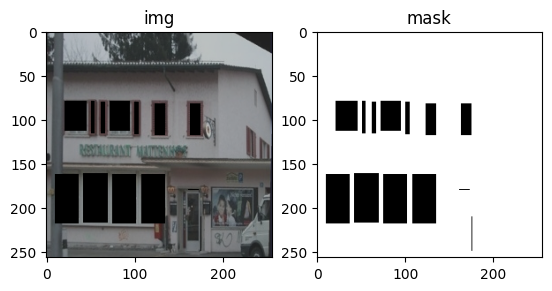

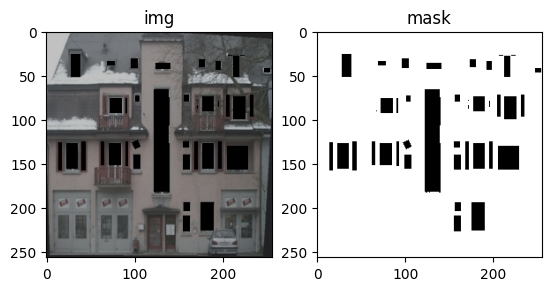

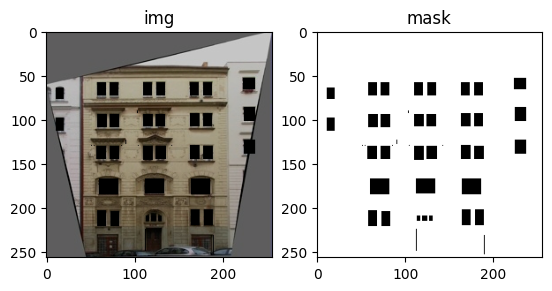

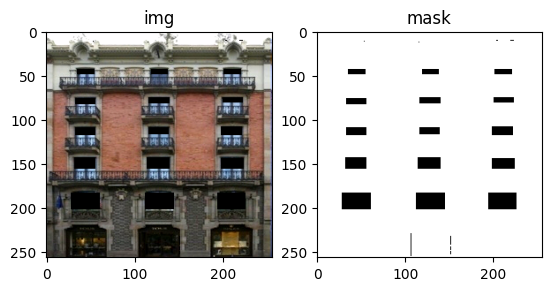

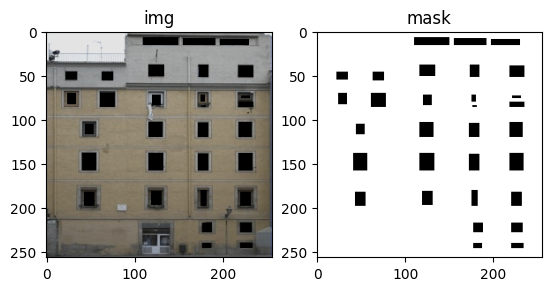

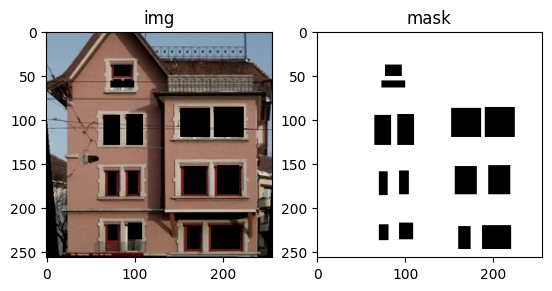

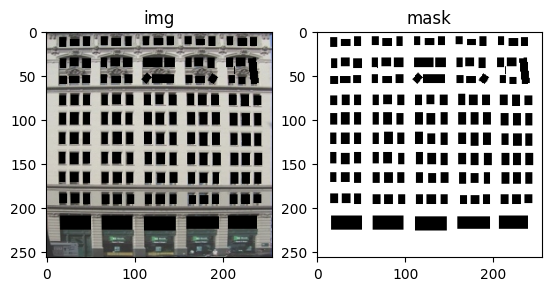

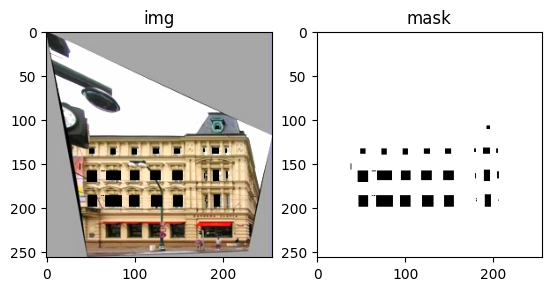

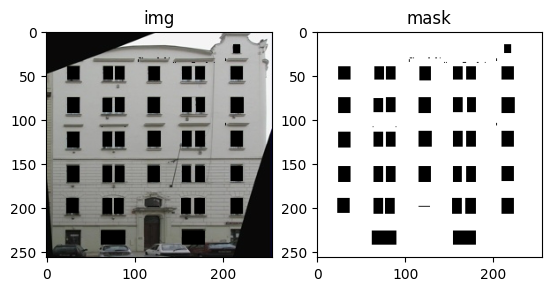

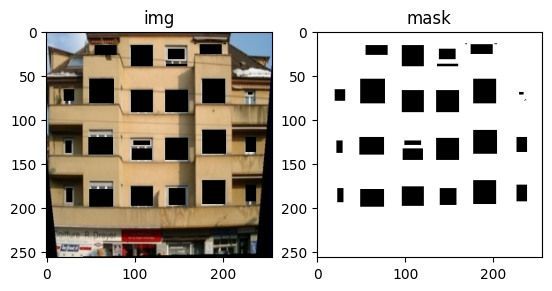

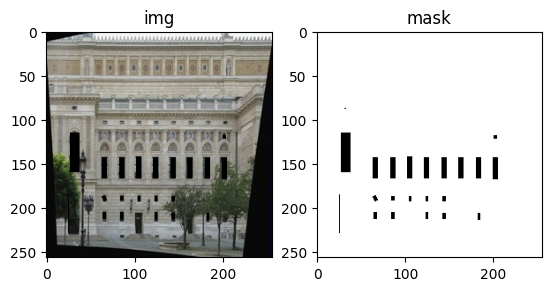

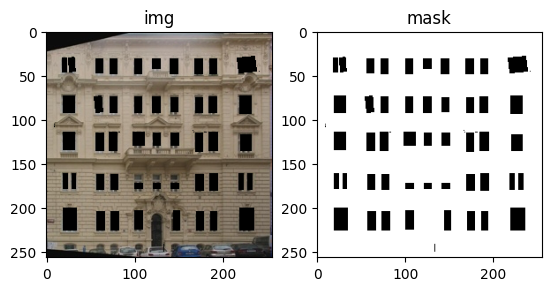

In [12]:
X, y = next(iter(train_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)
    
X, y = next(iter(val_loader))
for i in range(len(X)):
    img, mask = X[i], y[i]
    show_mask(img, mask, mean=mean, std=std)

# Эксперименты

### Сверточный слой

  
<br>
<br>
В одном сверточном слое может быть несколько сверток. В этом случае для каждой свертки на выходе получится своё изображение.  
<br>
<br>
Ядра свертки могут быть трёхмерными. Свертка трехмерного входа с трехмерным ядром происходит аналогично, просто скалярное произведение считается еще и по всем слоям изображения. Например, для усреднения информации о цветах исходного изображения, на первом слое можно использовать свертку размерности 3×w×h. На выходе такого слоя будет уже одно изображение (вместо трёх);  
<br>
<br>
Можно заметить, что применение операции свертки уменьшает изображение. Также пиксели, которые находятся на границе изображения участвуют в меньшем количестве сверток, чем внутренние. В связи с этим в сверточных слоях используется дополнение изображения (англ. padding). Выходы с предыдущего слоя дополняются пикселями так, чтобы после свертки сохранился размер изображения.
<br>
<br>
Еще одним параметром сверточного слоя является сдвиг (англ. stride). Хоть обычно свертка применяется подряд для каждого пикселя, иногда используется сдвиг, отличный от единицы — скалярное произведение считается не со всеми возможными положениями ядра, а только с положениями, кратными некоторому сдвигу s
.
<br>
<br>


### Архитектура FCN
<br>
<br>
<img src="https://eduherald.ru/i/2019/1/3441/image003.jpg">
<br>
Одна из проблем данной архитектуры заключается в том, что при распространении через несколько чередующихся сверточных и объединяющих слоев разрешение выходных карт объектов снижается. Поэтому прямые предсказания FCN обычно имеют низкое разрешение, что приводит к относительно нечетким границам объектов. Для решения этой проблемы было предложено множество более продвинутых подходов, основанных на FCN, включая SegNet, DeepLab-CRF и Dilated Convolutions.
<br>

In [13]:
class FCN(nn.Module):
    def __init__(self, in_channels, activation):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1), # 256 X 256
            nn.BatchNorm2d(64),
            activation,
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2) # 128 X 128
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            activation,
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2) # 64 X 64
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            activation,
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2) # 32 X 32
         )
        self.up = nn.Upsample(scale_factor=8) # 256 X 256 
        self.conv = nn.Conv2d(256, 1, 1)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.conv(x)
        x = self.up(x)
        return x
        

**Функция для отрисовки ровных прямоугольников на маске**

In [14]:
def rect_out(preds):
    p = preds.cpu().detach()
    p = (p > 0.5).numpy().astype("uint8")
    for i, img in enumerate(p):
        contours, _ = cv2.findContours(img, \
                                       cv2.RETR_EXTERNAL, \
                                       cv2.CHAIN_APPROX_SIMPLE)
        for con in contours:
            box = cv2.minAreaRect(con)
            box = np.intp(cv2.boxPoints(box))
            cv2.drawContours(img, [box], 0, (255,255,255), -1)
        p[i] = img
    return p

Dice Loss — популярная функция потерь, используемая для проблем семантической сегментации с экстремальным дисбалансом классов. Представленная в статье V-Net потеря используется для расчета перекрытия между прогнозируемым классом и классом истинности основания.
<br>
<img src="https://habrastorage.org/webt/ko/vx/mf/kovxmfvprphznrpthxjl1fsazeo.png">

In [15]:
class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, labels, smooth=1):
        preds = torch.sigmoid(preds)
        preds = preds.view(-1)
        labels = labels.view(-1)
        intersection = (preds * labels).sum()
        dice = ((2.0*intersection + smooth)/\
                    (preds.sum() + labels.sum() + smooth))
        return 1 - dice


In [16]:
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCN(3, nn.GELU()).to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 2 476 481'

### Функция обучения
<br>
<br>
В цикле for по количеству эпох модель обучается на данных из train_loader, а затем оценивается на данных из val_loader. В зависимости от значения mode ("train" или "val"), модель находится в режиме обучения или оценки.

<br>
<br>
Внутри цикла for для каждой эпохи расчета функции потерь выполняется пакетная загрузка данных из loader. Затем данные преобразуются в тензоры, копируются на устройство (device) и передаются модели. В режиме обучения, перед выполнением расчета функции потерь градиенты обнуляются (optimizer.zero_grad()), а после расчета функции потерь градиенты вычисляются и обновляются (loss.backward(), optimizer.step()). В режиме оценки (mode == "val") вычисление градиентов не происходит, а модель вызывается с аргументом torch.no_grad(), чтобы она не сохраняла градиенты.
<br>
<br>
Функция потерь (loss) суммируется для каждой итерации пакета, а затем усредняется на количество итераций (epoch_loss / len(loader)). Для режима обучения планировщик шагов (scheduler) принимает на вход значение функции потерь (epoch_loss) и производит соответствующие изменения в оптимизаторе.

In [17]:
def train(model, criterion, optimizer, scheduler, epochs):
    for epoch in range(epochs):
        for mode in ("train", "val"):
            if mode == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            epoch_loss = 0
            for i, (X, y) in enumerate(loader):
                X = X.to(device)
                y = y.to(device)

                if mode == "train":
                    optimizer.zero_grad()
                    preds = model(X).squeeze(1)
                    loss = criterion(preds, y)
                    loss.backward() 
                    optimizer.step()
                else:
                    with torch.no_grad():
                        preds = model(X).squeeze(1)
                        loss = criterion(preds, y)
                epoch_loss += loss.cpu().item()
            if mode == "train":
                scheduler.step(epoch_loss)
            print(f"{epoch}\t| {mode}\t| loss:\t{epoch_loss / len(loader)}")

In [18]:
train(model, criterion, optim, scheduler, 20)

0	| train	| loss:	0.6269210845232009
0	| val	| loss:	0.5384298115968704
1	| train	| loss:	0.4818829298019409
1	| val	| loss:	0.47499825358390807
2	| train	| loss:	0.44090462774038314
2	| val	| loss:	0.46489026248455045
3	| train	| loss:	0.43501368165016174
3	| val	| loss:	0.41275192201137545
4	| train	| loss:	0.4156496852636337
4	| val	| loss:	0.4095579206943512
5	| train	| loss:	0.4138666182756424
5	| val	| loss:	0.40033064782619476
6	| train	| loss:	0.403108523786068
6	| val	| loss:	0.4022498965263367
7	| train	| loss:	0.4004519388079643
7	| val	| loss:	0.4028485149145126
8	| train	| loss:	0.3959524750709534
8	| val	| loss:	0.39886200428009033
9	| train	| loss:	0.39174519032239913
9	| val	| loss:	0.39428918063640594


KeyboardInterrupt: ignored

**Выведем результаты**

In [19]:
def show_results(model):
    X, y = next(iter(val_loader))
    X = X.to(device)
    y = y.to(device)

    model.eval()
    preds = model(X).squeeze(1)
    pred = torch.sigmoid(preds).cpu().detach()
    # preds = rect_out(preds)
    for i in range(len(X)):
        show_mask(X[i].cpu().detach(), y[i].cpu(), pred[i], mean, std)
        print("accuracy: ", 1 - criterion(preds[i].cpu().detach(), y[i].cpu()).item())

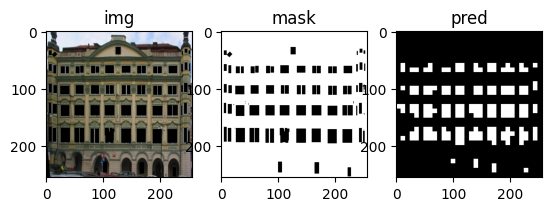

accuracy:  0.6878484487533569


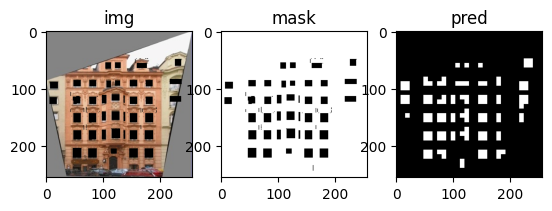

accuracy:  0.6746846437454224


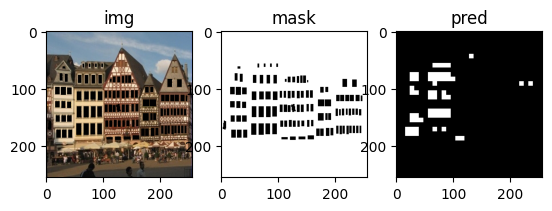

accuracy:  0.33017921447753906


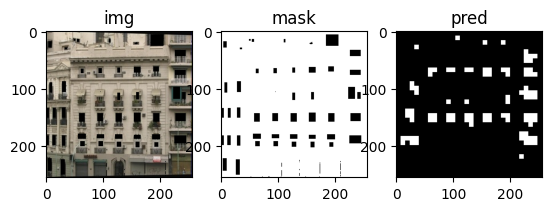

accuracy:  0.46283185482025146


In [20]:
show_results(model)

### Та же сеть, но с плавным увеличением размерности

In [21]:
class FCNConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
        )
    
    def forward(self, x):
        return self.layer(x)

        
class FCNWithDecoder(nn.Module):
    def __init__(self, activation=nn.ReLU(inplace=True), upsample_mode="nearest"):
        super().__init__()
        self.inconv = FCNConvBlock(3, 64, activation)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode=upsample_mode)
        
        # Encoder
        self.down_list = nn.ModuleList([])
        for i in [64, 128, 256]:
            self.down_list.append(FCNConvBlock(i, i * 2, activation))
        
        # Decoder
        self.up_list = nn.ModuleList([])
        for i in [256, 128, 64, 32]:
            self.up_list.append(FCNConvBlock(i * 2, i, activation))
        
        # Classifier
        self.classifier = nn.Conv2d(32, 1, 1)
        
    def forward(self, x):
        x = self.inconv(x)
        x = self.pool(x)
        
        # Encoder 
        for down_layer in self.down_list:
            x = down_layer(x)
            x = self.pool(x)
        
        # Decoder
        for up_layer in self.up_list:
            x = up_layer(x)
            x = self.up(x)
        x = self.classifier(x)
        return x

In [23]:
torch.cuda.empty_cache()
model = FCNWithDecoder().to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 7 042 209'

In [24]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.7163448616862297
0	| val	| loss:	0.6803712368011474
1	| train	| loss:	0.5997555971145629
1	| val	| loss:	0.5760913461446762
2	| train	| loss:	0.5099926322698594
2	| val	| loss:	0.44949911832809447
3	| train	| loss:	0.43773319870233535
3	| val	| loss:	0.4244637191295624
4	| train	| loss:	0.40360009372234346
4	| val	| loss:	0.41388053596019747
5	| train	| loss:	0.37886707186698915
5	| val	| loss:	0.37784866988658905
6	| train	| loss:	0.35272835940122604
6	| val	| loss:	0.37977921664714814
7	| train	| loss:	0.3445338010787964
7	| val	| loss:	0.3614449709653854
8	| train	| loss:	0.33810710310935976
8	| val	| loss:	0.34719919264316557
9	| train	| loss:	0.3267380312085152
9	| val	| loss:	0.34048076868057253


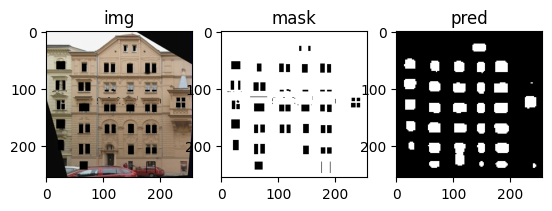

accuracy:  0.6059792637825012


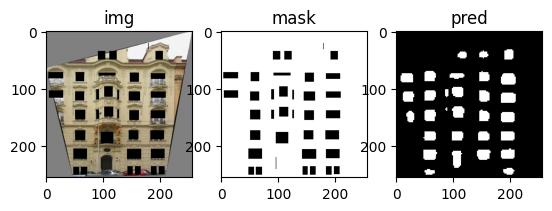

accuracy:  0.7029051184654236


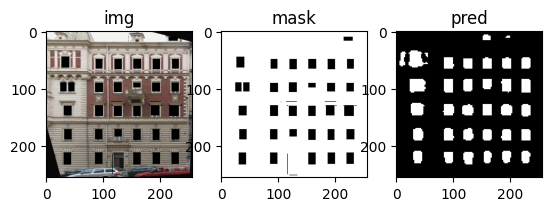

accuracy:  0.7320007681846619


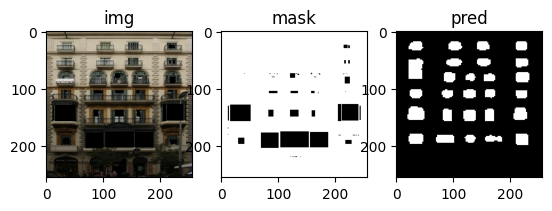

accuracy:  0.36965739727020264


In [25]:
show_results(model)

### ResNet
<br>
<img src="https://neurohive.io/wp-content/uploads/2019/01/resnet-neural-e1548772388921.png">
<br>
<br>
Этот слой уменьшает количество свойств в каждом слое, сначала используя свёртку 1х1 с меньшим выходом (обычно четверть от входа), затем идёт слой 3х3, а потом опять свёртка 1х1 в большее количество свойств. Как и в случае с Inception-модулями, это позволяет экономить вычислительные ресурсы, сохраняя богатство комбинаций свойств.

In [44]:
class ResnetBlock(nn.Module):
    def __init__(self, in_channels,\
                 out_channels,\
                 stride=1,\
                 activation=nn.ReLU()):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 4, 1),
            nn.BatchNorm2d(in_channels // 4),
            activation,
            nn.Conv2d(in_channels // 4, in_channels // 4, 3, stride, 1),
            nn.BatchNorm2d(in_channels // 4),
            activation,
            nn.Conv2d(in_channels // 4, out_channels, 1),
            nn.BatchNorm2d(out_channels),
        )
        self.down = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, stride),
            nn.BatchNorm2d(out_channels)
        ) if in_channels != out_channels else None
        self.act = activation
    
    
    def forward(self, x):
        identity = x
        x = self.layer(x)
        if self.down is not None:
            identity = self.down(identity)
        x += identity
        x = self.act(x)
        return x


    
class Resnet(nn.Module):
    def __init__(self, channels, layers, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            nn.Conv2d(3, channels, 7, 2, 3),
            nn.BatchNorm2d(channels),
            activation,
        )
        self.layer1 = self.make_layer(channels, channels, layers[0], 1, activation)
        self.layer2 = self.make_layer(channels, channels * 2, layers[1], 2, activation)
        self.layer3 = self.make_layer(channels * 2, channels * 4, layers[2], 2, activation)
        self.layer4 = self.make_layer(channels * 4, channels * 8, layers[3], 1, activation)
        
        self.outconv = nn.Sequential(
            nn.Upsample(scale_factor=8),
            nn.Conv2d(channels * 8, 1, 1)
        )
    
    
    def make_layer(self, in_channels, out_channels, layers, stride, activation):
        out = [ResnetBlock(in_channels, out_channels, stride, activation)]
        for _ in range(1, layers):
            out.append(ResnetBlock(out_channels, out_channels, activation=activation))
        out = nn.Sequential(*out)
        return out
    
    
    def forward(self, x):
        x = self.inconv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.outconv(x)
        return x
    

In [45]:
torch.cuda.empty_cache()
model = Resnet(64, [3, 4, 6, 3]).to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=2)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 1 284 545'

In [46]:
train(model, criterion, optim, scheduler, 10)

0	| train	| loss:	0.7169883161783218
0	| val	| loss:	0.6317267894744873
1	| train	| loss:	0.5469831466674805
1	| val	| loss:	0.5521573424339294
2	| train	| loss:	0.48307031244039533
2	| val	| loss:	0.48922042846679686
3	| train	| loss:	0.4480274707078934
3	| val	| loss:	0.45908810794353483
4	| train	| loss:	0.4463884487748146
4	| val	| loss:	0.4391194373369217
5	| train	| loss:	0.4266050845384598
5	| val	| loss:	0.42418990433216097
6	| train	| loss:	0.4153280407190323
6	| val	| loss:	0.42150731682777404
7	| train	| loss:	0.41550661325454713
7	| val	| loss:	0.4097378045320511
8	| train	| loss:	0.40493442565202714
8	| val	| loss:	0.41263666450977327
9	| train	| loss:	0.4039721369743347
9	| val	| loss:	0.4030123382806778


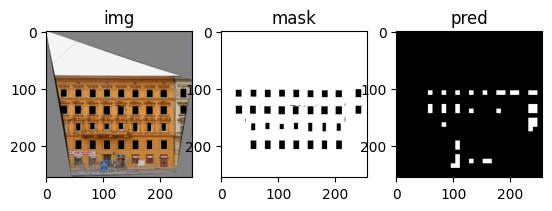

accuracy:  0.3676401376724243


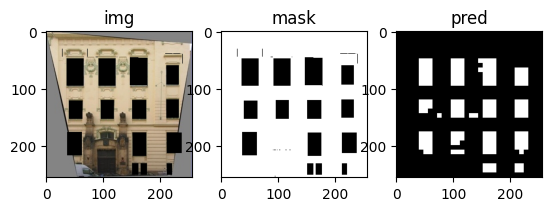

accuracy:  0.8237714767456055


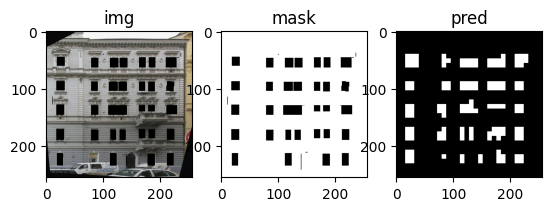

accuracy:  0.7141135334968567


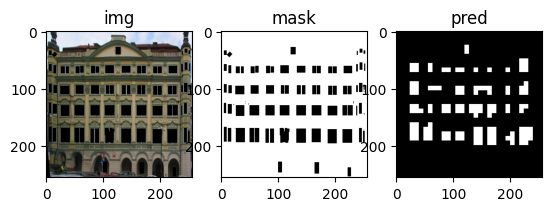

accuracy:  0.5673415064811707


In [47]:
show_results(model)

### Unet
<br>
<br>
U-Net считается одной из стандартных архитектур CNN для задач сегментации изображений.
<br>
Для U-Net хатактерно:

 - достижение высоких результатов в различных реальных задачах, особенно для биомедицинских приложений;
 - использование небольшого количества данных для достижения хороших результатов.
 <img src="https://neurohive.io/wp-content/uploads/2018/11/U-net-neural-network-medicine-768x512-1-570x380.png">
<br>
 Архитектура сети представляет собой последовательность слоёв свёртка+пулинг, которые сначала уменьшают пространственное разрешение картинки, а потом увеличивают его, предварительно объединив с данными картинки и пропустив через другие слои свёртки. 

In [48]:
class UnetConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation=None):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            activation
        )
    
    def forward(self, x):
        return self.layer(x)



class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation, inblock=None):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(in_channels, out_channels, activation),
            UnetConvBlock(out_channels, out_channels, activation)
        )
        self.pool = nn.MaxPool2d(2, 2)
        
        if inblock:
            self.inblock = inblock
        else:
            self.inblock = nn.Sequential(
                UnetConvBlock(out_channels, out_channels, activation),
                UnetConvBlock(out_channels, out_channels, activation)
            )
        
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.upconv = UnetConvBlock(out_channels, in_channels, activation)
        
        self.outconv = nn.Sequential(
            UnetConvBlock(in_channels + out_channels, in_channels, activation),
            UnetConvBlock(in_channels, in_channels, activation),
        )
    
    
    def forward(self, x):
        inconv = self.inconv(x)
        x = self.pool(inconv)
        
        x = self.inblock(x)
        
        x = self.up(x)
        x = self.upconv(x)
        x = torch.cat((inconv, x), dim=1)
        
        x = self.outconv(x)
        return x
        
        
        
class Unet(nn.Module):
    def __init__(self, channels=64, depth=3, activation=nn.ReLU(inplace=True)):
        super().__init__()
        self.inconv = nn.Sequential(
            UnetConvBlock(3, channels, activation),
            UnetConvBlock(channels, channels, activation),
        )
        
        if depth > 10 or depth < 2 or channels % 2 != 0:
            raise ValueError("depth shuld be less than " + \
                             "10 and greater then 1 " +\
                             "and channels should be 2**n")
        n = channels * 2 ** (depth - 1)
        block = UnetBlock(n // 2, n, activation)
        n = n // 2
        while n > channels:
            block = UnetBlock(n // 2, n, activation, block)
            n = n // 2
        self.block = block
        
        self.outconv = nn.Sequential(
            UnetConvBlock(channels, channels, activation),
            nn.Conv2d(channels, 1, 1)
        )
    
    
    def forward(self, x):
        x = self.inconv(x)
        x = self.block(x)
        x = self.outconv(x)
        return x
        

In [56]:
torch.cuda.empty_cache()
model = Unet(64, 4).to(device)
criterion = DiceLoss()
optim = Adam(model.parameters(), lr=0.001, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, \
                                                       mode="min",\
                                                       factor=0.2,\
                                                       threshold=0.01,\
                                                       patience=3)
n = sum([p.numel() for p in model.parameters()])
f"Number of parameters: {n // 1000_000} {(n // 1000 % 1000):03} {(n % 1000)}"

'Number of parameters: 14 096 897'

In [57]:
train(model, criterion, optim, scheduler, 30)

0	| train	| loss:	0.7006348982453346
0	| val	| loss:	0.6599264591932297
1	| train	| loss:	0.566272021830082
1	| val	| loss:	0.599510446190834
2	| train	| loss:	0.44033908694982526
2	| val	| loss:	0.4243994474411011
3	| train	| loss:	0.367683470249176
3	| val	| loss:	0.332642924785614
4	| train	| loss:	0.33135892301797865
4	| val	| loss:	0.31337088346481323
5	| train	| loss:	0.3105738922953606
5	| val	| loss:	0.28894324898719786
6	| train	| loss:	0.29485331028699874
6	| val	| loss:	0.29520061016082766
7	| train	| loss:	0.2988167732954025
7	| val	| loss:	0.29283544421195984
8	| train	| loss:	0.2843879655003548
8	| val	| loss:	0.2879318416118622
9	| train	| loss:	0.2754396677017212
9	| val	| loss:	0.27151809334754945
10	| train	| loss:	0.2682853236794472
10	| val	| loss:	0.2881536394357681
11	| train	| loss:	0.26209003627300265
11	| val	| loss:	0.2683095395565033
12	| train	| loss:	0.2554913952946663
12	| val	| loss:	0.26376254558563234
13	| train	| loss:	0.24778930991888046
13	| val	| lo

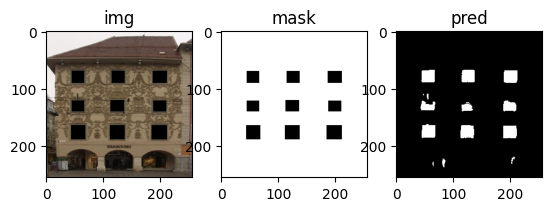

accuracy:  0.8533914089202881


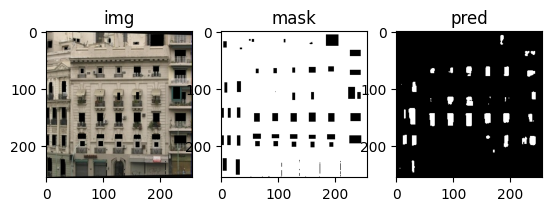

accuracy:  0.5209916234016418


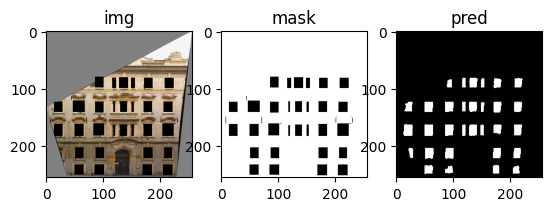

accuracy:  0.8147532343864441


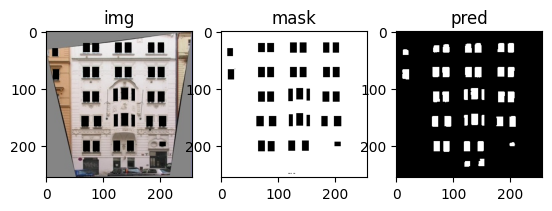

accuracy:  0.9005009531974792


In [58]:
show_results(model)

In [ ]:
model.eval()
X, y = next(iter(train_loader))
X = X.to(device)
y = y.to(device)

preds = model(X)

In [217]:

def count_windows(X, y, mask):
    thresh = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)[1]
    thresh = (thresh == 0).astype("uint8")
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img = np.zeros(mask.shape)
    for cont in contours:
        if cv2.contourArea(cont) > 60:
            con = cv2.minAreaRect(cont)
            con = np.intp(cv2.boxPoints(con))
            cv2.drawContours(img, [con], 0, (255,255,255), -1)
    show_mask(X, y, img, mean, std)
    return sum([1 for cont in contours if cv2.contourArea(cont) > 100])


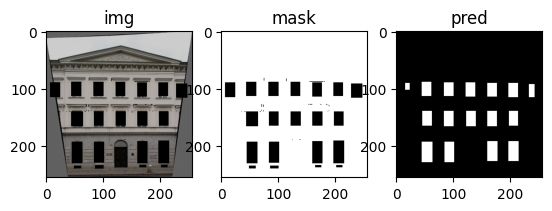

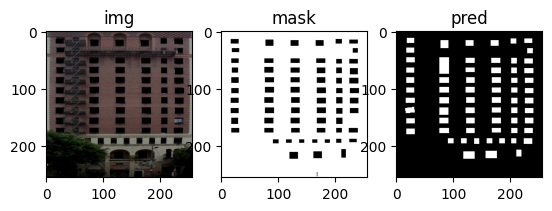

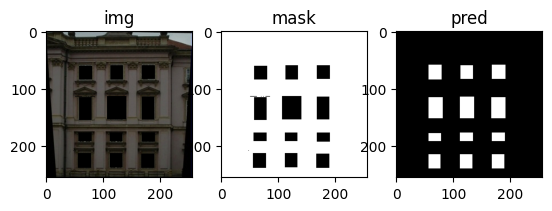

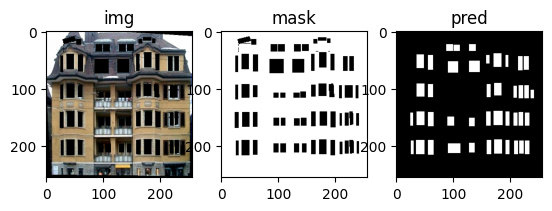

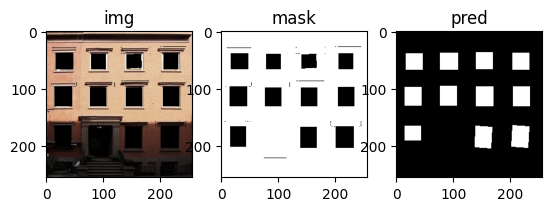

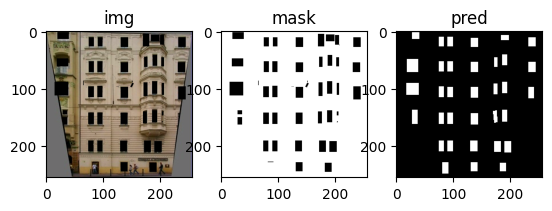

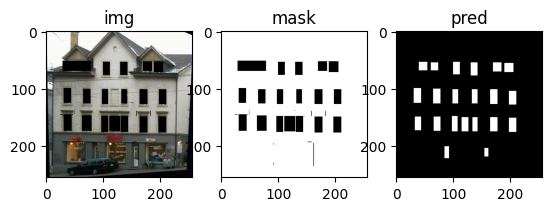

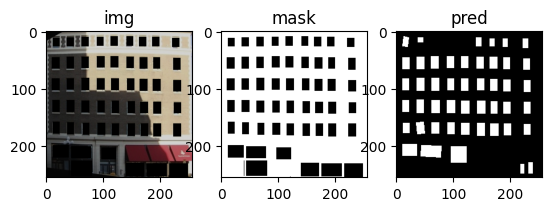

In [219]:

for i in range(len(preds)):
    p = preds[i].cpu().detach().squeeze().numpy().astype("uint8")
    count_windows(X[i].cpu().detach(), y[i].cpu(), p)

# Выводы

Очевидно, что детальность сегментации оставляет желать лучшего, когда речь идет о тщательном учете окон и точном определении этажей в здании. Скорее всего, причина данного явления кроется во многократных ошибках, допущенных при разметке входных данных.

Предлагаемые меры для дальнейшего улучшения процесса сегментации включают в себя исправление ошибок, допущенных при разметке данных, а также расширение функциональности с помощью увеличения глубины архитектуры U-net. Кроме того, рекомендуется добавить больше аугментаций, чтобы улучшить разнообразие данных, а также провести тестирование других эффективных архитектур, например, E-net.